<a href="https://colab.research.google.com/github/dabeesknees48/Numerai/blob/main/random_forests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
 !pip install numerapi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import gc
import scipy
import numerapi
import numpy as np
import pandas as pd
import time
import csv
import math
import matplotlib.pyplot as plt
import gc
import json

In [ ]:
def TicTocGenerator():
    ti = 0          
    tf = time.time()
    while True:
        ti = tf
        tf = time.time()
        yield tf-ti
TicToc = TicTocGenerator()
def toc(tempBool=True):
    tempTimeInterval = next(TicToc)
    if tempBool:
        print( "Elapsed time: %f seconds.\n" %tempTimeInterval )
def tic():
    toc(False)

tic()

In [ ]:
def read_csv(file_path):
    with open(file_path, 'r') as f:
        column_names = next(csv.reader(f))
        dtypes = {x: np.float16 for x in column_names if
                  x.startswith(('feature', 'target'))}
    return pd.read_csv(file_path, dtype=dtypes)

TARGET_NAME = f"target"
PREDICTION_NAME = f"prediction"
napi = numerapi.NumerAPI()
# download data
napi.download_current_dataset(unzip=True)
#getting the latest round information
current_ds = napi.get_current_round()
latest_round = os.path.join('numerai_dataset_'+str(current_ds))
#loading 
print("# Loading data...")
# The training data is used to train your model how to predict the targets.
training_data = read_csv(os.path.join(latest_round, "numerai_training_data.csv")).set_index("id")
# The tournament data is the data that Numerai uses to evaluate your model.
tournament_data = read_csv(os.path.join(latest_round, "numerai_tournament_data.csv")).set_index("id")

example_preds = read_csv(os.path.join(latest_round, "example_predictions.csv"))
validation_data = tournament_data[tournament_data.data_type == "validation"]

feature_names = [f for f in training_data.columns if f.startswith("feature")]
print(f"Loaded {len(feature_names)} features")
cols = feature_names+['TARGET_NAME']
toc()

2022-05-29 22:48:50,479 INFO numerapi.utils: starting download
./numerai_dataset_318.zip: 458MB [00:19, 23.5MB/s]                           
2022-05-29 22:49:09,935 INFO numerapi.base_api: unzipping file...


# Loading data...
Loaded 310 features
Elapsed time: 124.854786 seconds.



In [ ]:
# random forest hypertuned for best all around performance 
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(max_features=int(1),oob_score=True,max_depth=5)
rf.fit(training_data[feature_names],training_data['target'])

RandomForestRegressor(max_depth=5, max_features=1, oob_score=True)

training performance over time


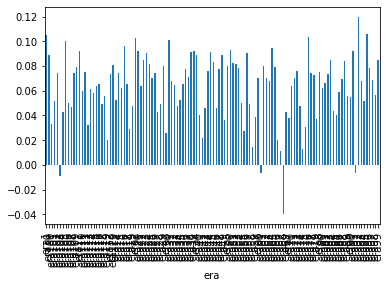

On training the correlation has mean 0.06278251281777746 and std 0.02684797677266523


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


training performance over time


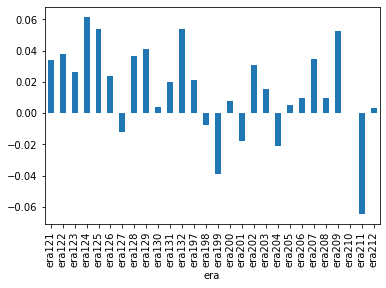

On validation the correlation has mean 0.014958322952005726 andstd 0.029220707017527575


In [ ]:
#results and validation score

def score(df):
    return correlation(df['tpreds'], df['target'])

def correlation(predictions, targets):
    ranked_preds = predictions.rank(pct=True, method="first")
    return np.corrcoef(ranked_preds, targets)[0, 1]

def payout(scores):
    return scores.clip(lower=-0.25, upper=0.25)

# Check the per-era correlations on the training set (in sample)
training_data['tpreds'] = rf.predict(training_data[feature_names])
train_correlations = training_data.groupby("era").apply(score)
train_correlations.plot(kind="bar")
print("training performance over time")
plt.show() 
print(f"On training the correlation has mean {train_correlations.mean()} and std {train_correlations.std()}")

# Check the per-era correlations on the validation set (out of sample)
validation_data['tpreds'] = rf.predict(validation_data[feature_names])
validation_correlations = validation_data.groupby("era").apply(score)
validation_correlations.plot(kind="bar")
print("training performance over time")
plt.show() 
print(f"On validation the correlation has mean {validation_correlations.mean()} and" f"std {validation_correlations.std()}")

In [ ]:
tournament_data[PREDICTION_NAME] = rf.predict(tournament_data[feature_names])

In [ ]:
tournament_data[PREDICTION_NAME].to_csv(f"tournament_predictions_{current_ds}.csv")
model_id = '' #base48
submission_id = napi.upload_predictions(f"tournament_predictions_{current_ds}.csv".format(current_ds), model_id=model_id)

2022-05-29 22:51:53,235 INFO numerapi.base_api: uploading predictions...
